In [1]:
#Importing all the neccesary tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

#Import Models and testing tools from Scikit-learn
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB


# Text Processing libraries
import nltk
from nltk.stem import PorterStemmer

In [33]:
#Reading the data from csv
# data set from kaggel : https://www.kaggle.com/datasets/purusinghvi/email-spam-classification-dataset
data = pd.read_csv("data/combined_data.csv")
data.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


# Proccessing Data

In [3]:
data.shape

(83448, 2)

In [4]:
data.isna().sum()

label    0
text     0
dtype: int64

In [5]:
data.duplicated().sum()

0

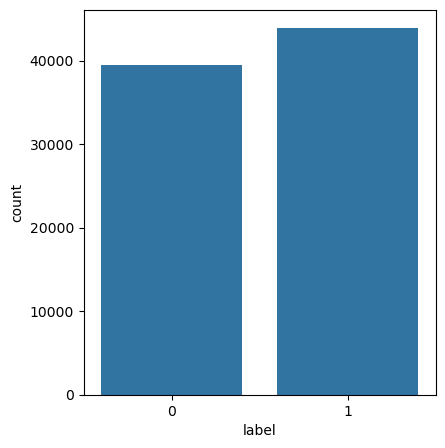

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.countplot(data,x='label')

plt.show();

In [7]:
data.dtypes

label     int64
text     object
dtype: object

## Text Preproccessing
> Lowering the text

> Remove punctutations

In [8]:
data['text'] = data['text'].str.lower()
data['text'] = data['text'].str.replace(r'[^\w\s]+', '',regex = True)
data.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


# Removing "and", "the", "an","to" & more

In [9]:
from nltk.corpus import stopwords
 
nltk.download('stopwords')
stop_words_list= stopwords.words('english')
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_list)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arbaazmir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Tokenization
1. Tokenization is the process of breaking down a sentence into a sequence of words, commonly referred to as "tokens."
2. Tokens encompass not only individual words but can also include phrases, symbols, or other meaningful units within the text.

In [10]:
nltk.download('punkt')


data['text'] = data['text'].apply(lambda x:nltk.word_tokenize(x))

[nltk_data] Downloading package punkt to /Users/arbaazmir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
data.head()

,label,text
0,1,"[ounce, feather, bowl, hummingbird, opec, mome..."
1,1,"[wulvob, get, medircations, online, qnb, ikud,..."
2,0,"[computer, connection, cnn, com, wednesday, es..."
3,1,"[university, degree, obtain, prosperous, futur..."
4,0,"[thanks, answers, guys, know, checked, rsync, ..."


# Stemming
1. In linguistics, the term "word stem" denotes the fundamental or root form of a word.
2. Stemming is the linguistic process of transforming words into their base forms or stems.

In [12]:
ps = PorterStemmer()
data['text'] = data['text'].apply(lambda x : [ps.stem(i) for i in x])

In [13]:
# setting x and y 
y = data['label']
x = data['text'].apply(lambda x: ' '.join(x))

vectorizer = TfidfVectorizer(min_df=50,max_features=5000)
x =  vectorizer.fit_transform(x).toarray()


In [14]:
# spliting train , test 
x_train , x_test , y_train,y_test = train_test_split(x,y,test_size=0.3, random_state=5)

In [15]:
x_train.shape,x_test.shape

((58413, 5000), (25035, 5000))

# Fitting Different Models and Evalution 

In [16]:
nb = GaussianNB()
nb2 = BernoulliNB()
nb3 = MultinomialNB()
VotingClassifiers = VotingClassifier(estimators=[('GaussianNB', nb),('BernoulliNB',nb2), ('MultinomialNB', nb3)], voting = 'soft')
decision_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier()
knn = KNeighborsClassifier()
models_list = {"VotingClassifiers": VotingClassifiers,
          "DecisionTreeClassifier":decision_clf,
          "RandomForestClassifier":rf_clf,
          "KNeighborsClassifier": knn 
         }

In [17]:
def fit_and_eval(models,x_train,y_train,x_test,y_test):
    '''
    This function is use to fit and evaluate models.
    Results are saved in a data dictonary
    '''
    np.random.seed(42)
    results_score={}
    for name,model in models.items():
        #fitting the model
        model.fit(x_train,y_train)
        #evaluate the model
        results_score[name]=model.score(x_test,y_test)
        
    return results_score
    

In [18]:
model_scores_eval = fit_and_eval(models=models_list,x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test)


In [19]:
model_scores_eval

{'VotingClassifiers': 0.969243059716397,
 'DecisionTreeClassifier': 0.9598162572398642,
 'RandomForestClassifier': 0.9851408028759736,
 'KNeighborsClassifier': 0.8392250848811663}

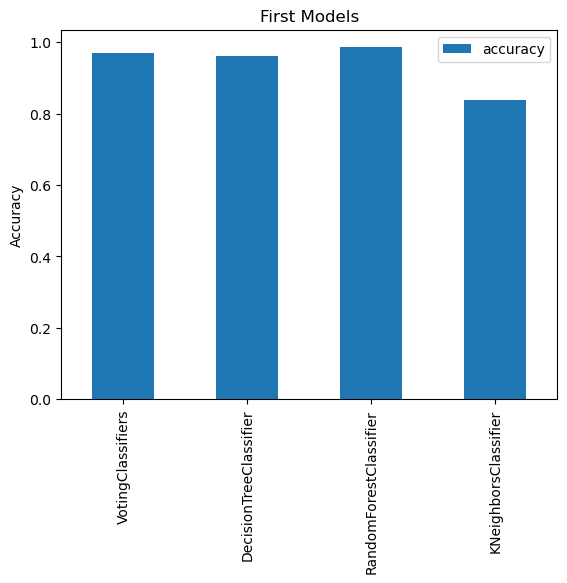

In [20]:
models_compare = pd.DataFrame(model_scores_eval, index=["accuracy"])

# Display the DataFrame
models_compare.T.plot.bar(ylabel= "Accuracy", title= "First Models");

In [21]:
def evaluate_classifier(classifier, x_train, y_train, x_test, y_test, title):
    # Making predictions
    y_pred = classifier.predict(x_test)

    # Confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='mako', square=True,
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Classification report
    print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.96      0.97     11838
           1       0.97      0.97      0.97     13197

    accuracy                           0.97     25035
   macro avg       0.97      0.97      0.97     25035
weighted avg       0.97      0.97      0.97     25035



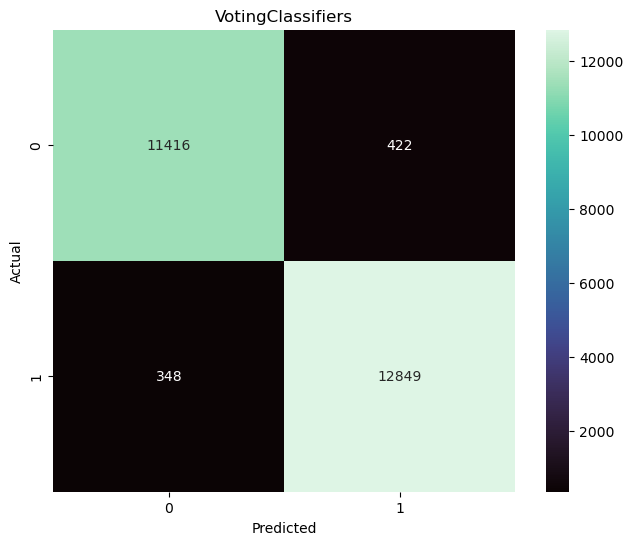

In [22]:
evaluate_classifier(VotingClassifiers,x_train,y_train,x_test,y_test,"VotingClassifiers")

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     11838
           1       0.96      0.96      0.96     13197

    accuracy                           0.96     25035
   macro avg       0.96      0.96      0.96     25035
weighted avg       0.96      0.96      0.96     25035



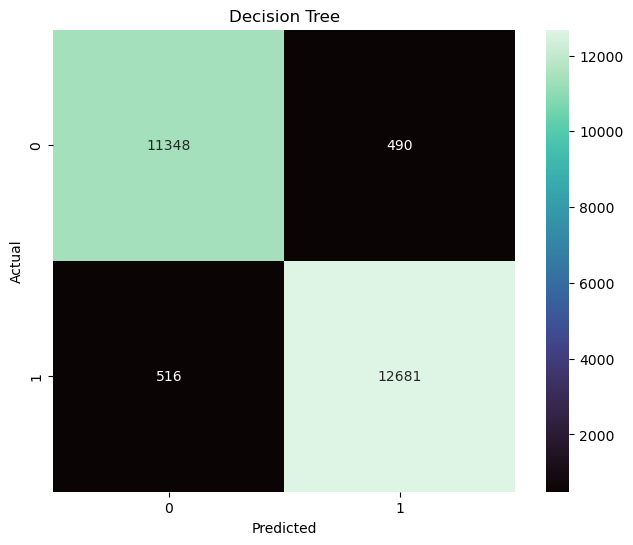

In [23]:
evaluate_classifier(decision_clf,x_train,y_train,x_test,y_test,"Decision Tree")

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     11838
           1       0.98      0.99      0.99     13197

    accuracy                           0.99     25035
   macro avg       0.99      0.98      0.99     25035
weighted avg       0.99      0.99      0.99     25035



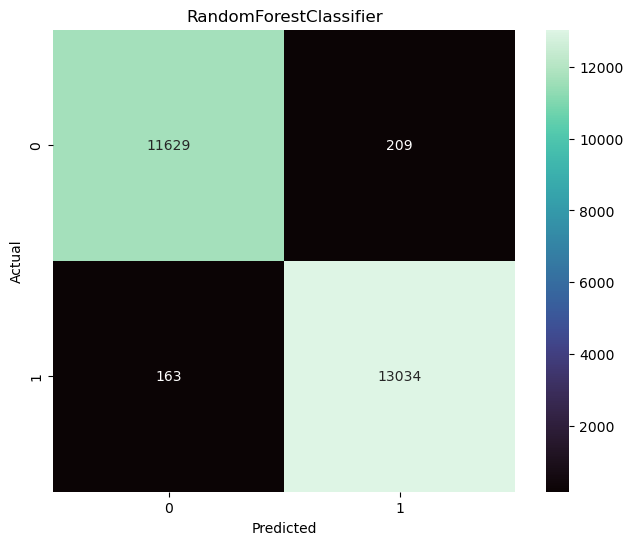

In [24]:
evaluate_classifier(rf_clf,x_train,y_train,x_test,y_test,"RandomForestClassifier")

              precision    recall  f1-score   support

           0       0.99      0.67      0.80     11838
           1       0.77      0.99      0.87     13197

    accuracy                           0.84     25035
   macro avg       0.88      0.83      0.83     25035
weighted avg       0.87      0.84      0.83     25035



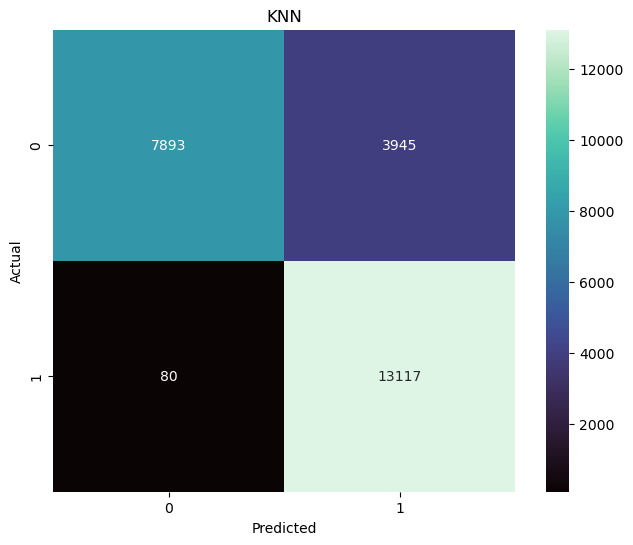

In [25]:
evaluate_classifier(knn,x_train,y_train,x_test,y_test,"KNN")

In [26]:
def preprocess(inp):
    inp = inp.lower()
    inp = inp.replace(r'[^\w\s]+', '')
    inp = [word for word in inp.split() if word not in (stop_words_list)]
    inp = ' '.join([ps.stem(i) for i in inp])
    inputToModel = vectorizer.transform([inp]).toarray()
    return inputToModel

In [27]:
def app(input_text, model):
    """
    Process the input text using a given model and print the output.

    Parameters:
    - input_text (str): The input text to be processed.
    - model: The machine learning model used for prediction.

    Returns:
    None
    """
    try:
        print('Input:', input_text)
        

        processed_array = preprocess(input_text)

        predict = model.predict(processed_array)

        print('Output:', predict[0])

    except Exception as e:
        print('Error:', str(e))


In [28]:
app("Hey you! Look over my profile and, if you like it, match me back. I'm hoping to do something in the next few days. Simply looking to have some fun with no strings attached. I'm a really giving person in bed, and I'm looking for someone who is the same. So all you have to do is match me back and I'll know you like what you see ;) View Request",rf_clf)

Input: Hey you! Look over my profile and, if you like it, match me back. I'm hoping to do something in the next few days. Simply looking to have some fun with no strings attached. I'm a really giving person in bed, and I'm looking for someone who is the same. So all you have to do is match me back and I'll know you like what you see ;) View Request
Output: 1


In [29]:
app("Hello, Thank you for your response. I have attached my Detailed CV, O-level mark sheet and the first page of my passport. For the letter of recommendation, I can get it from one of my lecturers at INTI University. Should I get it from her? Could you also provide me with your WhatsApp or Telegram number for faster communication?  Sincerely,",rf_clf)

Input: Hello, Thank you for your response. I have attached my Detailed CV, O-level mark sheet and the first page of my passport. For the letter of recommendation, I can get it from one of my lecturers at INTI University. Should I get it from her? Could you also provide me with your WhatsApp or Telegram number for faster communication?  Sincerely,
Output: 0


In [30]:
app("Our records show you overpaid for (a product or service). Kindly supply your bank routing and account number to receive your refund.",rf_clf)

Input: Our records show you overpaid for (a product or service). Kindly supply your bank routing and account number to receive your refund.
Output: 1


In [31]:
app("I'm sorry to let you know that I've been facing significant challenges that have hindered my ability to attend classes and keep up with the coursework. Unfortunately, I have missed all the classes for CGEB4112 up to this point due to two major issues I am currently dealing with. The first issue is related to my living situation. Previously, I shared an apartment with a flatmate; however, they left in April, and since then, I have been living alone in a three-bedroom apartment. This sudden change has been quite bothersome for me, leading to difficulties in sleeping at night and making it challenging to wake up early in the morning. As a result, my ability to attend early classes has been severely impacted. ",rf_clf)

Input: I'm sorry to let you know that I've been facing significant challenges that have hindered my ability to attend classes and keep up with the coursework. Unfortunately, I have missed all the classes for CGEB4112 up to this point due to two major issues I am currently dealing with. The first issue is related to my living situation. Previously, I shared an apartment with a flatmate; however, they left in April, and since then, I have been living alone in a three-bedroom apartment. This sudden change has been quite bothersome for me, leading to difficulties in sleeping at night and making it challenging to wake up early in the morning. As a result, my ability to attend early classes has been severely impacted. 
Output: 0


In [32]:
app("The Jobs Weekly Newsletter Dear Alex Ibn, For many of us, parts of job searching might feel at times  -- or at worst, downright miserable. One of the most common complaints is the waiting game of hearing back from an employer and how frustrating that is.  Although waiting can be nerve-wracking, it's important to not to give into behaviors that create more stress (like obsessively refreshing our email inboxes, or sending too many follow up emails.) Instead, focus on more effective and productive things to do while you wait. You may want to use this time to grow your professional network or take a course to help hone your skills, but most importantly, you should continue your job search. Even if you think you've found the one,  keep looking and applying for jobs in case you find something even better!  We'd like to help you find your next great remote or hybrid job. If you're ready to find higher quality, vetted remote job listings, then joining FlexJobs will be a game changer! Take a quick tour of our premium job search service to learn more.  Wishing you a good and successful rest of the week. Many cheers, The FlexJobs Team FlexJobs Sun 10 Fun, Uplifting Remote Jobs That Are Hiring 10 Fun, Uplifting Remote Jobs That Are Hiring Prepping for an upcoming job interview can be nerve-racking, but a mock interview can be like a personal rehearsal before the real interview. Learn how to effectively set up your own mock interview. Discover these fun remote jobs hiring now > What Is the Hidden Job Market? 8 Ways to Tap In What Is the Hidden Job Market? 8 Ways to Tap In Have you ever ordered “secret menu” items at a restaurant? They might not be openly listed, but savvy customers know and love them. Similarly, an unadvertised job could be the perfect fit. Learn how to strategize your job search for the hidden job market > Top 20 Must-Have Skills to Put on Your Resume Top 20 Must-Have Skills to Put on Your Resume Writing a good resume is a difficult balancing act. When thinking about  your skills it’s very important to know what  to include that will be relevant to the job and catch the eye of the hiring manager. Here are the best skills to put on your resume > Questions to Ask to Uncover Potential Red Flags Questions to Ask to Uncover Potential Red Flags When searching for a new job, it’s essential to look for any signs as to whether or not the company or work environment will be a good fit for you. We've outlined some questions to help you.Here are the top questions to ask a hiring manager to spot red flags > FlexJobs Sun Great Remote Jobs Hiring Now! Every week we highlight interesting Work from Anywhere in the US remote jobs, as well as Work from Anywhere in the World jobs. We want to provide you with an idea of the variety, quality, and depth of the hand-screened, professional jobs currently listed on our site. As a non-member, you can subscribe to FlexJobs today for full access to these and 24,000 more hand-screened remote jobs all in one easy place! View Current Customer Service Jobs >> View Current Data Entry Jobs >> View Current Internet & Ecommerce Jobs >> View Current Fashion & Beauty Jobs >> View Current Virtual Admin Jobs >> View Current Medical & Health Jobs >> View Current Writing Jobs >> View Current HR & Recruiting Jobs >> View Current Accounting & Finance Jobs >> View Current Teaching Jobs >>",rf_clf)

Input: The Jobs Weekly Newsletter Dear Alex Ibn, For many of us, parts of job searching might feel at times  -- or at worst, downright miserable. One of the most common complaints is the waiting game of hearing back from an employer and how frustrating that is.  Although waiting can be nerve-wracking, it's important to not to give into behaviors that create more stress (like obsessively refreshing our email inboxes, or sending too many follow up emails.) Instead, focus on more effective and productive things to do while you wait. You may want to use this time to grow your professional network or take a course to help hone your skills, but most importantly, you should continue your job search. Even if you think you've found the one,  keep looking and applying for jobs in case you find something even better!  We'd like to help you find your next great remote or hybrid job. If you're ready to find higher quality, vetted remote job listings, then joining FlexJobs will be a game changer! Ta